In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


tf.random.set_seed(42)


import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(42)

file_path = '/content/drive/My Drive/an-ninh-mang/dataset/UNSW-NB15/UNSW_NB15_training-set.csv'
df_train = pd.read_csv(file_path)

file_path = '/content/drive/My Drive/an-ninh-mang/dataset/UNSW-NB15/UNSW_NB15_testing-set.csv'
df_test = pd.read_csv(file_path)

df_train['Data_Type'] = 1
df_test['Data_Type'] = 0

df = pd.concat([df_train, df_test], ignore_index=True)

df

Mounted at /content/drive


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Data_Type
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,0,0,0,1,1,0,Normal,0,1
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,2,0,0,0,1,6,0,Normal,0,1
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,3,0,0,0,2,6,0,Normal,0,1
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,3,1,1,0,2,1,0,Normal,0,1
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,40,0,0,0,2,39,0,Normal,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,2,0,0,0,2,1,0,Normal,0,0
257669,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,0,0,0,3,2,0,Normal,0,0
257670,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,0,0,0,1,1,1,Normal,0,0
257671,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,0,0,0,1,1,1,Normal,0,0


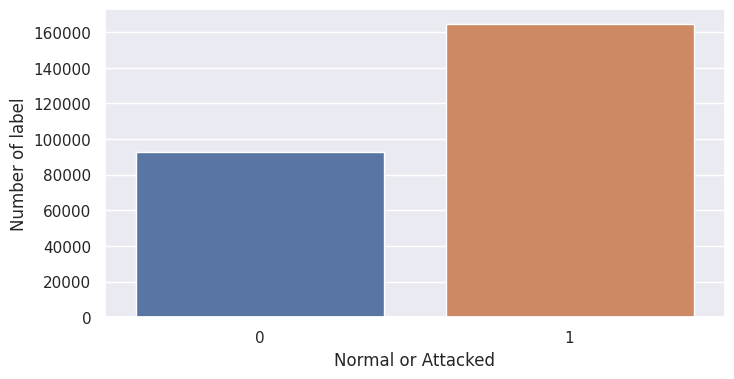

In [2]:
# make a plot number of labels
sns.set(rc={'figure.figsize':(8, 4)})
plt.xlabel('Status')
sns.set_theme()
ax = sns.countplot(x='label', data=df)
ax.set(xlabel='Normal or Attacked', ylabel='Number of label')
plt.show()

In [3]:
list_drop = ['attack_cat', 'id']
df.drop(list_drop,axis=1,inplace=True)

In [4]:
df.shape

(257673, 44)

# **Fillna**

In [5]:
import warnings
warnings.filterwarnings('ignore')

df = df.drop_duplicates()
df2 = df.copy()


In [6]:
df2.fillna(df2.mean(), inplace=True)
print(df2.isna().sum().to_numpy())

df2

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,Data_Type
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,0,1
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,0,1
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,0,1
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,0,1
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257660,0.811914,tcp,-,FIN,10,6,588,268,18.474862,254,...,1,4,0,0,0,1,4,0,0,0
257663,0.000004,udp,-,INT,2,0,104,0,250000.000600,254,...,1,1,0,0,0,1,1,0,0,0
257664,5.167410,tcp,-,FIN,108,24,138067,1042,25.351192,254,...,1,1,0,0,0,1,3,0,0,0
257668,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,2,0,0,0,2,1,0,0,0


# **Encoding the categorical data - OneHot Encoding**



In [7]:
data_cat = df2.select_dtypes(exclude=[np.number])
data_cat.describe(include='all')

,proto,service,state
count,155221,155221,155221
unique,133,13,11
top,tcp,-,FIN
freq,116646,93736,111629


In [8]:
columns_to_encode = data_cat.columns
last_two_columns = df2.iloc[:, -2:]
df2 = df2.iloc[:, :-2]

one_hot_encoded = pd.get_dummies(df2, columns=columns_to_encode)
df2 = pd.concat([one_hot_encoded, last_two_columns], axis=1)


In [9]:
df2

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no,label,Data_Type
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,0,1,0,0,0,0,0,0,0,1
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,...,0,1,0,0,0,0,0,0,0,1
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,...,0,1,0,0,0,0,0,0,0,1
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,0,1,0,0,0,0,0,0,0,1
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257660,0.811914,10,6,588,268,18.474862,254,252,5.222228e+03,2207.130127,...,0,1,0,0,0,0,0,0,0,0
257663,0.000004,2,0,104,0,250000.000600,254,0,1.040000e+08,0.000000,...,0,0,1,0,0,0,0,0,0,0
257664,5.167410,108,24,138067,1042,25.351192,254,252,2.117719e+05,1546.616211,...,0,1,0,0,0,0,0,0,0,0
257668,0.000005,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,...,0,0,1,0,0,0,0,0,0,0


In [10]:
df2.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# **Feature scaling - Standard Scaler**

In [11]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = df2.columns[:-2]
sta = StandardScaler()
df2[columns_to_scale] = sta.fit_transform(df2[columns_to_scale])

df2

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no,label,Data_Type
0,-0.229231,-0.136812,-0.185044,-0.059363,-0.126284,-0.298761,1.030404,1.054953,-0.211713,-0.356514,...,-0.008027,0.624906,-0.411085,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,1
1,-0.114711,-0.090510,0.059197,-0.057220,0.102985,-0.298720,-0.739161,1.037733,-0.211741,-0.193156,...,-0.008027,0.624906,-0.411085,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,1
2,0.096207,-0.125236,-0.098841,-0.058886,-0.054975,-0.299324,-0.739161,1.037733,-0.211774,-0.339213,...,-0.008027,0.624906,-0.411085,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,1
3,0.108888,-0.102085,-0.127576,-0.057697,-0.123008,-0.299329,-0.739161,1.037733,-0.211768,-0.358209,...,-0.008027,0.624906,-0.411085,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,1
4,-0.158152,-0.113661,-0.170677,-0.058120,-0.125758,-0.299144,1.049031,1.037733,-0.211740,-0.358002,...,-0.008027,0.624906,-0.411085,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257660,-0.079600,-0.113661,-0.170677,-0.057877,-0.125758,-0.299284,1.049031,1.037733,-0.211756,-0.358589,...,-0.008027,0.624906,-0.411085,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,0
257663,-0.255557,-0.159963,-0.213779,-0.060057,-0.127227,2.051430,1.049031,-1.131907,0.292183,-0.359317,...,-0.008027,-1.600240,2.432584,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,0
257664,0.864325,0.453537,-0.041373,0.561216,-0.121517,-0.299219,1.049031,1.037733,-0.210755,-0.358807,...,-0.008027,0.624906,-0.411085,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,0
257668,-0.255557,-0.159963,-0.213779,-0.060057,-0.127227,1.581253,1.049031,-1.131907,0.191390,-0.359317,...,-0.008027,-1.600240,2.432584,-0.002538,-0.113989,-0.023269,-0.002538,-0.002538,0,0


In [12]:
print(df2['label'].value_counts())

0    86096
1    69125
Name: label, dtype: int64


In [13]:
# from sklearn.preprocessing import MinMaxScaler
# mm = MinMaxScaler()
# columns_to_scale = df.columns[:-1]
# df2[columns_to_scale] = mm.fit_transform(df2[columns_to_scale])
# df2

# **Splitting the dataset**

In [14]:
train_data = df2[df2['Data_Type'] == 1]
test_data = df2[df2['Data_Type'] == 0]

train_data = train_data.drop('Data_Type', axis=1)
test_data = test_data.drop('Data_Type', axis=1)

train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [15]:
test_data.shape

(53952, 197)

In [16]:
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

X_test = test_data.drop('label', axis=1)
y_test = test_data['label']


# **Select feature**


In [17]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X = train_data.drop(columns=['label'])
Y = train_data['label']

mutual_info = SelectKBest(score_func=mutual_info_classif, k=21)
X_new = mutual_info.fit_transform(X, Y)

selected_feature_names = list(X.columns[mutual_info.get_support(indices=True)])
selected_feature_names.append('label')

print(selected_feature_names)


['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_state_ttl', 'label']


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_classification_with_plot(truth, predicted, threshold=0.5, class_names=['Bengin', 'Malicious']):
    predicted_binary = (predicted > threshold).astype(int)

    confusion = confusion_matrix(truth, predicted_binary)


    accuracy = accuracy_score(truth, predicted_binary)
    print("Accuracy:", accuracy)

    precision, recall, f1, _ = precision_recall_fscore_support(truth, predicted_binary, average='binary')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

    plot_confusion_matrix(confusion, class_names)

    return accuracy




Epoch 1/10
1583/1583 [==============================] - 9s 5ms/step - loss: 0.2798 - accuracy: 0.8857 - val_loss: 0.4622 - val_accuracy: 0.7361
Epoch 2/10
1583/1583 [==============================] - 6s 4ms/step - loss: 0.2480 - accuracy: 0.8953 - val_loss: 0.4442 - val_accuracy: 0.7356
Epoch 3/10
1583/1583 [==============================] - 5s 3ms/step - loss: 0.2415 - accuracy: 0.8959 - val_loss: 0.4661 - val_accuracy: 0.7360
Epoch 4/10
1583/1583 [==============================] - 6s 4ms/step - loss: 0.2358 - accuracy: 0.8967 - val_loss: 0.4393 - val_accuracy: 0.7359
Epoch 5/10
1583/1583 [==============================] - 5s 3ms/step - loss: 0.2318 - accuracy: 0.8969 - val_loss: 0.4185 - val_accuracy: 0.7358
Epoch 6/10
1583/1583 [==============================] - 5s 3ms/step - loss: 0.2284 - accuracy: 0.8966 - val_loss: 0.3792 - val_accuracy: 0.7389
Epoch 7/10
1583/1583 [==============================] - 6s 4ms/step - loss: 0.2257 - accuracy: 0.8968 - val_loss: 0.4114 - val_accuracy:

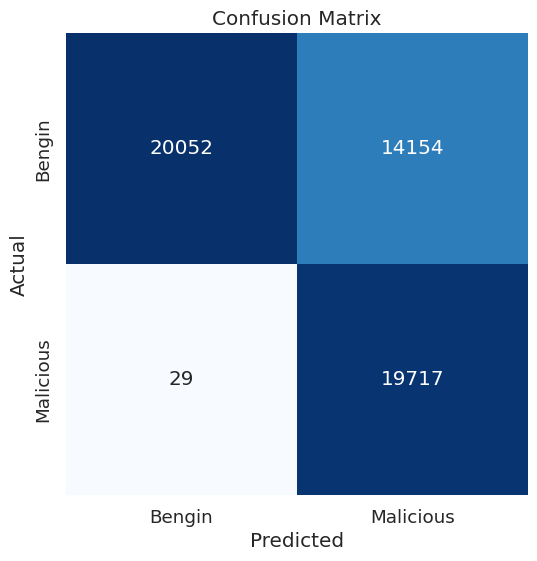

In [19]:
train_list = selected_feature_names
X_train_copy = X_train[train_list[:-1]]
X_test_copy = X_test[train_list[:-1]]

model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(len(train_list)-1,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_copy, y_train, epochs=10, batch_size=64, validation_data=(X_test_copy, y_test))
y_pred = model.predict(X_test_copy)

accuracy = evaluate_classification_with_plot(y_test, y_pred, class_names=['Bengin', 'Malicious'])

